In [4]:
import torch
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest


In [5]:
import pandas as pd
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu, kruskal, f_oneway, wilcoxon
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np

## code book

In [11]:


def create_codebook(df, units_dict=None, detailed_labels=None):
    codebook = pd.DataFrame(columns=['Name', 'Type', 'Width', 'Decimals', 'Label', 'Values', 
                                     'Missing', 'MissingRate', 'Align', 'Measure', 'Mean', 
                                     'Min', 'Max', 'StdDev', 'Median', 'Unit', 'ImbalanceWarning', 'OutlierWarning'])
    rows = []
    outlier_columns = []  # 用於儲存有離群值的欄位名稱

    for col in df.columns:
        # 初步判斷數據類型
        data_type = type(df[col].iloc[0])

        # 判斷數據類型並分類為 Scale 或 Nominal
        if pd.api.types.is_numeric_dtype(df[col]):
            measure = 'Scale'
            decimals = 2 if df[col].dtype == 'float64' else 0
            column_width = df[col].astype(str).str.len().max()  # 字符串表示的最大長度
        elif isinstance(df[col].iloc[0], (str, list)):
            measure = 'Nominal'
            decimals = 0
            column_width = df[col].astype(str).str.len().max()
        elif isinstance(df[col].iloc[0], torch.Tensor) or isinstance(df[col].iloc[0], tf.Tensor):
            measure = 'Scale'
            decimals = 2
            column_width = len(str(df[col].iloc[0]))
        else:
            measure = 'Nominal'
            decimals = 0
            column_width = len(str(df[col].iloc[0]))

        # 計算缺失值
        missing_values = df[col].isnull().sum()
        missing_rate = round(missing_values / len(df) * 100, 2)

        # 標籤為變數名稱（可以用 detailed_labels 進行更具描述性的標籤命名）
        label = detailed_labels[col] if detailed_labels and col in detailed_labels else col

        # 如果是分類變數，列出唯一值，並檢查是否存在類別不平衡
        if measure == 'Nominal':
            unique_vals = df[col].unique()
            values = ', '.join([str(val) for val in unique_vals])
            imbalance_warning = "Yes" if df[col].value_counts(normalize=True).max() > 0.8 else "No"
            outlier_warning = 'N/A'  # 對分類變數不檢查離群值
        else:
            values = 'Scale data - None'
            imbalance_warning = 'N/A'
            
            # 計算四分位距來檢測離群值
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # 判斷是否存在離群值
            outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
            outlier_rate = outliers / len(df[col]) * 100
            outlier_warning = "Yes" if outlier_rate > 5 else "No"  # 若離群值超過5%，則觸發警告

            # 如果有離群值，將欄位名稱加入列表
            if outlier_warning == "Yes":
                outlier_columns.append(col)

        # 對齊方式：數字為右對齊，字符串為左對齊
        align = 'Right' if pd.api.types.is_numeric_dtype(df[col]) else 'Left'

        # 計算數值變數的統計摘要
        if measure == 'Scale':
            mean_val = round(df[col].mean(), 2) if pd.api.types.is_numeric_dtype(df[col]) else 'N/A'
            min_val = df[col].min()
            max_val = df[col].max()
            std_dev = round(df[col].std(), 2)
            median_val = df[col].median()
        else:
            mean_val, min_val, max_val, std_dev, median_val = 'N/A', 'N/A', 'N/A', 'N/A', 'N/A'

        # 單位（可根據變數名稱或使用者提供的 units_dict 進行設置）
        unit = units_dict[col] if units_dict and col in units_dict else 'N/A'

        # 添加行到資料字典
        rows.append({
            'Name': col,
            'Type': str(data_type),
            'Width': column_width,
            'Decimals': decimals,
            'Label': label,
            'Values': values,
            'Missing': missing_values,
            'MissingRate': f'{missing_rate}%',
            'Align': align,
            'Measure': measure,
            'Mean': mean_val,
            'Min': min_val,
            'Max': max_val,
            'StdDev': std_dev,
            'Median': median_val,
            'Unit': unit,
            'ImbalanceWarning': imbalance_warning,
            'OutlierWarning': outlier_warning
        })

    # 使用 pd.concat() 創建資料字典 DataFrame
    codebook = pd.concat([pd.DataFrame([row]) for row in rows], ignore_index=True)

    # 繪製有離群值的欄位
    if outlier_columns:
        plot_outlier_columns(df, outlier_columns)

    return codebook

# 定義一個函數來對有離群值的欄位進行 KDE 和假設檢定的視覺化
def plot_outlier_columns(df, outlier_columns):
    # 設定每行的圖表數量，這裡設置為 2 個
    n_cols_per_row = 2
    n_outliers = len(outlier_columns)
    n_rows = (n_outliers + n_cols_per_row - 1) // n_cols_per_row  # 計算需要的行數

    fig, axes = plt.subplots(n_rows, n_cols_per_row, figsize=(12, 3 * n_rows))  # 動態生成子圖
    axes = axes.flatten()  # Flatten 確保每一個 subplot 都可以迭代

    for i, col in enumerate(outlier_columns):
        ax = axes[i]

        # KDE 繪製
        sns.kdeplot(df[col], color='blue', label=f"{col} KDE", fill=True, ax=ax)

        # 計算 IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 假設檢定 - 常態性檢查
        stat, p_value = normaltest(df[col].dropna())
        
        # 提取統計數據
        mean_val = round(df[col].mean(), 2)
        std_dev = round(df[col].std(), 2)
        min_val = df[col].min()
        max_val = df[col].max()

        # 標註 p-value 和統計摘要
        ax.set_title(f'KDE Plot of {col} with Outliers\n'
                     f'Name: {col}, Mean: {mean_val}, StdDev: {std_dev}, Min: {min_val}, Max: {max_val}\n'
                     f'Normality Test p-value: {p_value:.4f}')
        ax.axvline(x=lower_bound, color='green', linestyle='--', label='Lower Bound (1.5 * IQR)')
        ax.axvline(x=upper_bound, color='red', linestyle='--', label='Upper Bound (1.5 * IQR)')
        
        # 顯示離群值
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        ax.scatter(outliers[col], np.zeros(len(outliers)), color='red', label='Outliers', zorder=5)

        # 設置圖例
        ax.legend()

    # 隱藏空白子圖（如果有）
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # 調整圖表佈局
    plt.tight_layout()
    plt.show()



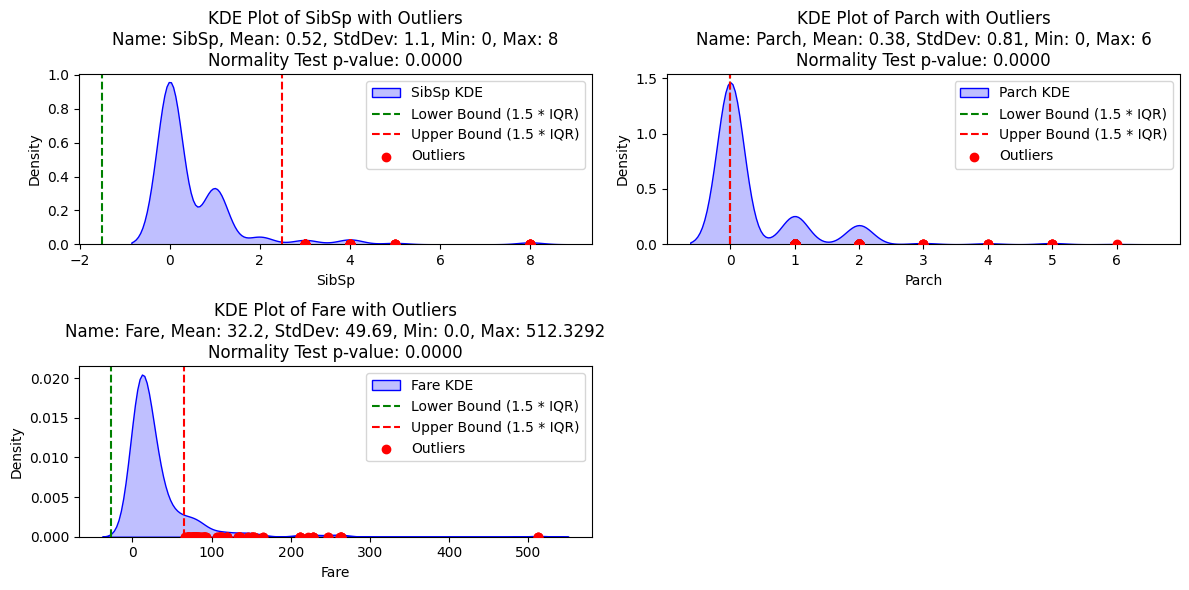

,Name,Type,Width,Decimals,Label,Values,Missing,MissingRate,Align,Measure,Mean,Min,Max,StdDev,Median,Unit,ImbalanceWarning,OutlierWarning
0,PassengerId,<class 'numpy.int64'>,3,0,PassengerId,Scale data - None,0,0.0%,Right,Scale,446.0,1,891,257.35,446.0,N/A,N/A,No
1,Survived,<class 'numpy.int64'>,1,0,Survived,Scale data - None,0,0.0%,Right,Scale,0.38,0,1,0.49,0.0,N/A,N/A,No
2,Pclass,<class 'numpy.int64'>,1,0,Pclass,Scale data - None,0,0.0%,Right,Scale,2.31,1,3,0.84,3.0,N/A,N/A,No
3,Name,<class 'str'>,82,0,Name,"Braund, Mr. Owen Harris, Cumings, Mrs. John Br...",0,0.0%,Left,Nominal,N/A,N/A,N/A,N/A,N/A,N/A,No,N/A
4,Sex,<class 'str'>,6,0,Sex,"male, female",0,0.0%,Left,Nominal,N/A,N/A,N/A,N/A,N/A,N/A,No,N/A
5,Age,<class 'numpy.float64'>,4,2,Age,Scale data - None,177,19.87%,Right,Scale,29.7,0.42,80.0,14.53,28.0,N/A,N/A,No
6,SibSp,<class 'numpy.int64'>,1,0,SibSp,Scale data - None,0,0.0%,Right,Scale,0.52,0,8,1.1,0.0,N/A,N/A,Yes
7,Parch,<class 'numpy.int64'>,1,0,Parch,Scale data - None,0,0.0%,Right,Scale,0.38,0,6,0.81,0.0,N/A,N/A,Yes
8,Ticket,<class 'str'>,18,0,Ticket,"A/5 21171, PC 17599, STON/O2. 3101282, 113803,...",0,0.0%,Left,Nominal,N/A,N/A,N/A,N/A,N/A,N/A,No,N/A
9,Fare,<class 'numpy.float64'>,8,2,Fare,Scale data - None,0,0.0%,Right,Scale,32.2,0.0,512.3292,49.69,14.4542,N/A,N/A,Yes


In [12]:
# 加载Titanic数据集
path = r'C:\Users\xdxd2\Documents\GitHub\iSpan_python-DA-cookbooks\advance\competition\Inferential_Statistics\case\train.csv'
df = pd.read_csv(path, encoding="utf-8-sig")


create_codebook(df)

## 檢定報表

In [45]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

class UnivariateAnalysisModule:
    
    def __init__(self, alpha=0.05):
        self.alpha = alpha
        self.results = []

    def calculate_statistics(self, data):
        """計算描述性統計量"""
        return {
            'mean': data.mean(),
            'std': data.std(),
            'median': data.median(),
            'iqr': stats.iqr(data)
        }
    
    def cohen_d(self, x, y):
        """計算Cohen's d效應量"""
        return (x.mean() - y.mean()) / np.sqrt((x.var() + y.var()) / 2)
    
    def normality_test(self, data):
        """Shapiro-Wilk 正態性檢定"""
        if len(data) < 3:
            return False, np.nan
        stat, p_value = stats.shapiro(data)
        return p_value > 0.05, p_value
    
    def variance_homogeneity_test(self, group_data):
        """Levene 方差齊性檢定"""
        if len(group_data) < 2:
            return np.nan
        return stats.levene(*group_data)[1]

    def analyze_variable(self, df, group_col, var):
        """對每個變數進行分析"""
        # 獲取不同組別的數據
        groups = df[group_col].unique()
        group_data = [df[df[group_col] == group][var].dropna() for group in groups]

        # 確認有多少組
        n_groups = len(groups)
        
        # 初始化 levene_p 以防止未賦值錯誤
        levene_p = 'N/A'
        
        # 單變量檢測（兩組數據）
        if n_groups == 2:
            data_group1, data_group2 = group_data
            # 描述性統計量
            stats_group1 = self.calculate_statistics(data_group1)
            stats_group2 = self.calculate_statistics(data_group2)
            
            # Shapiro-Wilk 正態性檢定
            shapiro_p1 = stats.shapiro(data_group1)[1] if len(data_group1) >= 3 else np.nan
            shapiro_p2 = stats.shapiro(data_group2)[1] if len(data_group2) >= 3 else np.nan
            
            # Levene 方差齊性檢定
            levene_p = self.variance_homogeneity_test([data_group1, data_group2])
            
            # 根據正態性與方差齊性選擇適當的檢定方法
            if shapiro_p1 > 0.05 and shapiro_p2 > 0.05:
                if levene_p > 0.05:
                    # t 檢定
                    t_stat, p_value = stats.ttest_ind(data_group1, data_group2, equal_var=True)
                    test_used = "t 檢定"
                    effect_size = self.cohen_d(data_group1, data_group2)
                else:
                    # Welch's t 檢定
                    t_stat, p_value = stats.ttest_ind(data_group1, data_group2, equal_var=False)
                    test_used = "Welch's t 檢定"
                    effect_size = self.cohen_d(data_group1, data_group2)
            else:
                # Mann-Whitney U 檢定
                u_stat, p_value = stats.mannwhitneyu(data_group1, data_group2)
                test_used = "Mann-Whitney U 檢定"
                effect_size = (u_stat - (len(data_group1) * len(data_group2)) / 2) / (len(data_group1) * len(data_group2) / 2)

        # 多變量檢測（多於兩組數據）
        elif n_groups > 2:
            # 正態性檢定（只檢測第一組數據）
            normal, _ = self.normality_test(group_data[0])

            if normal:
                # 方差齊性檢定
                levene_p = self.variance_homogeneity_test(group_data)
                
                if levene_p > 0.05:
                    # ANOVA
                    stat, p_value = stats.f_oneway(*group_data)
                    test_used = "ANOVA"
                else:
                    # Kruskal-Wallis 檢定
                    stat, p_value = stats.kruskal(*group_data)
                    test_used = "Kruskal-Wallis 檢定"
            else:
                # 非正態分佈，直接使用 Kruskal-Wallis 檢定
                stat, p_value = stats.kruskal(*group_data)
                test_used = "Kruskal-Wallis 檢定"

            effect_size = 'N/A'  # 多組檢定通常不計算 Cohen's d
            
        else:
            raise ValueError(f"本模組僅支持兩組或多組數據進行分析，檢測到的組數為: {n_groups}")

        # 儲存結果
        result = "是" if p_value < self.alpha else "否"
        self.results.append({
            'Variable': var,
            'Shapiro p (Group 1)': shapiro_p1 if n_groups == 2 else 'N/A',
            'Shapiro p (Group 2)': shapiro_p2 if n_groups == 2 else 'N/A',
            "Levene's p-value": levene_p,
            'Test Used': test_used, 'p-value': p_value,
            'Effect Size': effect_size, 'Result': result
        })
    
    def run_analysis(self, df=None, codebook=None, group_col=None, variables=None):
        """運行分析過程，允許傳入 dataframe 或 codebook"""
        
        # 如果使用 codebook 進行分析
        if codebook is not None:
            df = df if df is not None else pd.read_csv('titanic.csv')  # 假設 codebook 中有 dataframe
            group_col = 'Pclass'  # 使用 codebook 提供的分組欄位（此處假設為 Pclass）
            variables = codebook[codebook['Measure'] == 'Scale']['Name'].tolist()  # 使用 codebook 提取數值型變數
        
        # 檢查必要參數
        if df is None or group_col is None or variables is None:
            raise ValueError("請提供 df、group_col 和 variables 或 codebook")
        
        # 逐個變數進行分析
        for var in variables:
            self.analyze_variable(df, group_col, var)
        
        # 將結果轉換為 DataFrame
        df_results = pd.DataFrame(self.results)
        
        # Bonferroni 多重比較校正
        pvals = df_results['p-value'].dropna().values
        _, pvals_corrected, _, _ = multipletests(pvals, alpha=self.alpha, method='bonferroni')
        
        # 添加校正後的 p 值
        df_results.loc[df_results['p-value'].notna(), 'p-value_corrected'] = pvals_corrected
        df_results['Result_corrected'] = ['是' if p < self.alpha else '否' for p in pvals_corrected]
        
        return df_results



# 示例使用方法

## 一般版本

In [46]:

# 初始化模組
analysis_module = UnivariateAnalysisModule()

# 手動指定 df、group_col 和 variables
group_col = 'Pclass'  # 分類變數
variables = ['Fare', 'Age']  # 要進行檢測的變數

# 使用自定義的 df 進行分析
results_df = analysis_module.run_analysis(df=df, group_col=group_col, variables=variables)
print(results_df)



  Variable Shapiro p (Group 1) Shapiro p (Group 2) Levene's p-value  \
0     Fare                 N/A                 N/A              N/A   
1      Age                 N/A                 N/A              N/A   

           Test Used       p-value Effect Size Result  p-value_corrected  \
0  Kruskal-Wallis 檢定  7.586097e-96         N/A      是       1.517219e-95   
1  Kruskal-Wallis 檢定  1.428880e-21         N/A      是       2.857760e-21   

  Result_corrected  
0                是  
1                是  


## codebook version

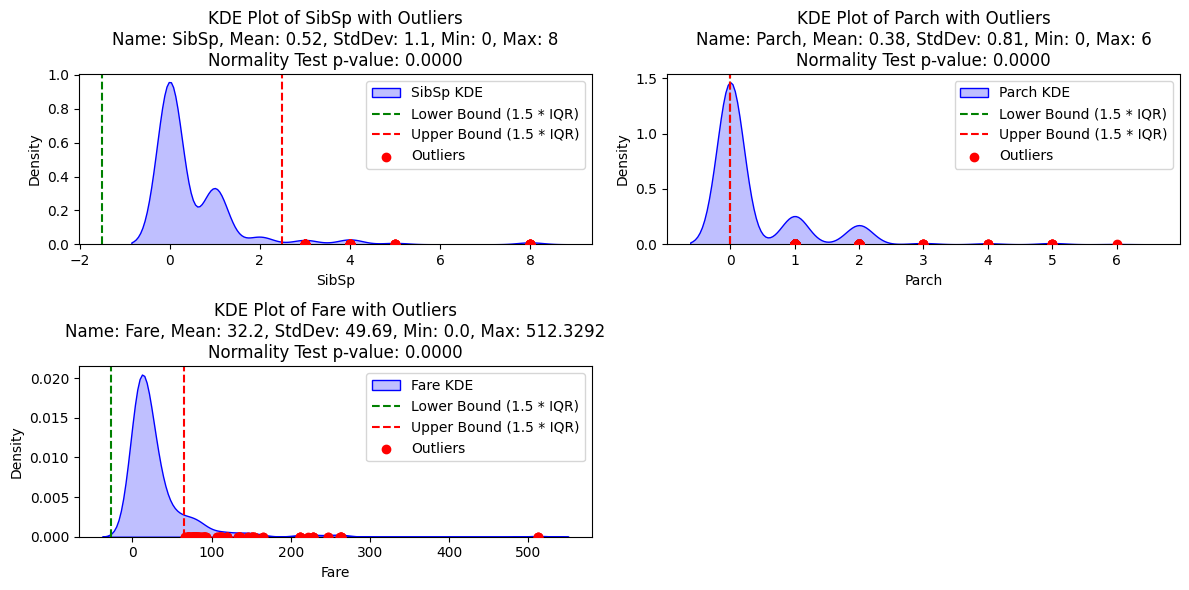

In [49]:
# 創建 codebook 並進行統計檢定
codebook = create_codebook(df, units_dict={'Age': 'years', 'Fare': 'USD'}, detailed_labels={'Age': 'Passenger Age', 'Fare': 'Ticket Fare'})

In [44]:
codebook

,Name,Type,Width,Decimals,Label,Values,Missing,MissingRate,Align,Measure,Mean,Min,Max,StdDev,Median,Unit,ImbalanceWarning,OutlierWarning
0,PassengerId,<class 'numpy.int64'>,3,0,PassengerId,Scale data - None,0,0.0%,Right,Scale,446.0,1,891,257.35,446.0,N/A,N/A,No
1,Survived,<class 'numpy.int64'>,1,0,Survived,Scale data - None,0,0.0%,Right,Scale,0.38,0,1,0.49,0.0,N/A,N/A,No
2,Pclass,<class 'numpy.int64'>,1,0,Pclass,Scale data - None,0,0.0%,Right,Scale,2.31,1,3,0.84,3.0,N/A,N/A,No
3,Name,<class 'str'>,82,0,Name,"Braund, Mr. Owen Harris, Cumings, Mrs. John Br...",0,0.0%,Left,Nominal,N/A,N/A,N/A,N/A,N/A,N/A,No,N/A
4,Sex,<class 'str'>,6,0,Sex,"male, female",0,0.0%,Left,Nominal,N/A,N/A,N/A,N/A,N/A,N/A,No,N/A
5,Age,<class 'numpy.float64'>,4,2,Passenger Age,Scale data - None,177,19.87%,Right,Scale,29.7,0.42,80.0,14.53,28.0,years,N/A,No
6,SibSp,<class 'numpy.int64'>,1,0,SibSp,Scale data - None,0,0.0%,Right,Scale,0.52,0,8,1.1,0.0,N/A,N/A,Yes
7,Parch,<class 'numpy.int64'>,1,0,Parch,Scale data - None,0,0.0%,Right,Scale,0.38,0,6,0.81,0.0,N/A,N/A,Yes
8,Ticket,<class 'str'>,18,0,Ticket,"A/5 21171, PC 17599, STON/O2. 3101282, 113803,...",0,0.0%,Left,Nominal,N/A,N/A,N/A,N/A,N/A,N/A,No,N/A
9,Fare,<class 'numpy.float64'>,8,2,Ticket Fare,Scale data - None,0,0.0%,Right,Scale,32.2,0.0,512.3292,49.69,14.4542,USD,N/A,Yes


In [50]:
# 初始化模組
analysis_module = UnivariateAnalysisModule()

# 使用 codebook 進行分析
results_with_codebook = analysis_module.run_analysis(df=df, codebook=codebook)

results_with_codebook

C:\Users\xdxd2\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\Users\xdxd2\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_morestats.py:3189: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


,Variable,Shapiro p (Group 1),Shapiro p (Group 2),Levene's p-value,Test Used,p-value,Effect Size,Result,p-value_corrected,Result_corrected
0,PassengerId,N/A,N/A,N/A,Kruskal-Wallis 檢定,5.653085e-01,N/A,否,1.000000e+00,否
1,Survived,N/A,N/A,N/A,Kruskal-Wallis 檢定,4.819647e-23,N/A,是,3.373753e-22,是
2,Pclass,N/A,N/A,NaN,Kruskal-Wallis 檢定,5.482209e-194,N/A,是,3.837546e-193,是
3,Age,N/A,N/A,N/A,Kruskal-Wallis 檢定,1.428880e-21,N/A,是,1.000216e-20,是
4,SibSp,N/A,N/A,N/A,Kruskal-Wallis 檢定,4.372871e-01,N/A,否,1.000000e+00,否
5,Parch,N/A,N/A,N/A,Kruskal-Wallis 檢定,5.917775e-01,N/A,否,1.000000e+00,否
6,Fare,N/A,N/A,N/A,Kruskal-Wallis 檢定,7.586097e-96,N/A,是,5.310268e-95,是
